# WIP; Next Step: Clean up 
# Multi-Level System Example

In [1436]:
using OpenQuantumTools, OrdinaryDiffEq, Plots

In [1437]:
"""
Construct a Projection Matrix with projecting on d'th eigenvector for a 
"""
Π(d::Int, n::Int) = setindex!(zeros(n), 1, d) |> diagm |> Hermitian
flop(val, d1::Int, d2::Int, n::Int) = setindex!(zeros(typeof(val), n,n,), val, d1, d2) |> Hermitian
sigmax(d1, d2, n) = flop(1., d1, d2, n)
sigmay(d1, d2, n) = flop(1.0im, d1, d2, n)

sigmay (generic function with 1 method)

In [1438]:
sigmay(1, 2, 3)

3×3 Hermitian{ComplexF64, Matrix{ComplexF64}}:
 0.0+0.0im  0.0+1.0im  0.0+0.0im
 0.0-1.0im  0.0+0.0im  0.0+0.0im
 0.0-0.0im  0.0-0.0im  0.0+0.0im

In [370]:
[sigmax(1, 2, 3), sigmax(2, 3, 3), sigmay(1, 2, 3), sigmay(2, 3, 3)]

4-element Vector{Hermitian}:
 [0.0 1.0 0.0; 1.0 0.0 0.0; 0.0 0.0 0.0]
 [0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 1.0 0.0]
 ComplexF64[0.0 + 0.0im 0.0 + 1.0im 0.0 + 0.0im; 0.0 - 1.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im 0.0 - 0.0im 0.0 + 0.0im]
 ComplexF64[0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im 0.0 + 0.0im 0.0 + 1.0im; 0.0 - 0.0im 0.0 - 1.0im 0.0 + 0.0im]

## Leakge and Stark Shift Errors in Single Qubit Gate Operations

#### DRAG Pulses.

`DRAG` or Derivative Removal by Adiabatic Gate is a pulse optimization technique used in the field of superconducting quantum computing. 
More details can be found in the following reference: [arXiv:0901.0534](https://arxiv.org/abs/0901.0534)


### 1. Trivial Case: Free Evolution

For the context of this example, we will model the transmon with 3 energy levels.

In this approximation, the transmon can be defined by its `Frequency` and `Anharmonicity`.

The transmon hamiltonian in the lab Frame is given by
$$H_{0} =  \omega \Pi_{1} + (\omega + \eta) \Pi_{2}$$
$$H_{rf}(t) =  $$
$$H_{lab} = H_0 + H_{rf}(t) $$

In [371]:
import ForwardDiff

In [372]:
ndim = 3
ω = 4.5 # GHz
η = -0.21 # GHz

-0.21

In [373]:
# Constructing the Hamiltonian

In [437]:
# Frequency of the Interaction Picture Frame
# for now we assume we are in the interaction picture with respect to the 0-1 transition
ωi = ω;
# constructing the free hamiltonian
δvec = [ω, ω+η] .- ωi
h0 = ComplexF64.(setindex!(zeros(ndim), δvec, 2:ndim) |> diagm |> Hermitian)
h1ops = [h0]
h1coeffs = [one]

1-element Vector{typeof(one)}:
 one (generic function with 47 methods)

In [375]:
# unit makes sure that the hamiltonian is specified in GHz instead of 2pi * GHz
H1 = DenseHamiltonian(h1coeffs, h1ops, unit=:h)
ψ0 = [1., 0., 0.]
# define total evolution time in (ns)
tmax = 8.0 #ns
dt = 0.1
# annealing object
a1 = Annealing(H1, ψ0)

Annealing with DenseHamiltonian{ComplexF64} and u0 Vector{Float64}
u0 size: (3,)

In [376]:
ψsol1 = solve_schrodinger(a1, 1, tspan=(0, tmax), alg=Tsit5(), abstol=1e-6, reltol=1e-6, saveat=dt);

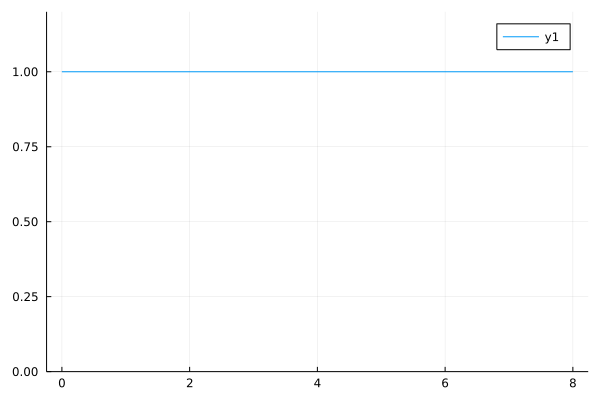

In [377]:
# we expect that phase is  0.21 *  2π * t => 0.21 
plot(ψsol1.t, abs2.(hcat(ψsol1.u...)[1,:]))
ylims!(0,1.2)

In [378]:
ψ01 = [1., 1., 0.]
ψ01 ./= norm(ψ01)
a11 = Annealing(H1, ψ01)

Annealing with DenseHamiltonian{ComplexF64} and u0 Vector{Float64}
u0 size: (3,)

In [379]:
ψsol11 = solve_schrodinger(a11, 1, tspan=(0, tmax), alg=Tsit5(), abstol=1e-6, reltol=1e-6, saveat=dt);

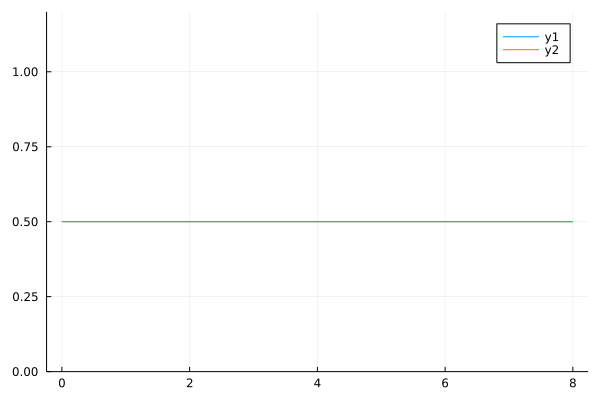

In [380]:
# we expect that phase is  0.21 *  2π * t => 0.21 
plot(ψsol11.t, abs2.(hcat(ψsol11.u...)[1,:]))
plot!(ψsol11.t, abs2.(hcat(ψsol11.u...)[2,:]))
ylims!(0,1.2)

### Interaction Picture
In the interaction picture the hamiltonian will look like:
$$ H_I = \delta_1 \Pi_1 + \delta_2 \Pi_2 + \mathcal{E}(t) (\sigma_x^{01} + \lambda \sigma_x^{12}) $$ 

### 2. Evolution Under Constant Amplitude RF Pulse
Next we would like to explore the behavior under a constant amplitude pulse, and show that the population can leak to the second excited state.

In [440]:
# currently only looking at on-resonance behavior
ωd = 4.5
# for now we assume we are in the interaction picture with respect to the rf-drive frame
ωi = ωd;
# constructing the free hamiltonian
δvec = [ω, 2ω+η] - ωi*[1, 2]
h0 = ComplexF64.(setindex!(zeros(ndim), δvec, 2:ndim) |> diagm)

3×3 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im    0.0+0.0im
 0.0+0.0im  0.0+0.0im    0.0+0.0im
 0.0+0.0im  0.0+0.0im  -0.21+0.0im

In [382]:
# realistic value of λ ( coupling normalizations )
λ = [1, sqrt(2)]
tg = 40
# drive amplitude
# Sanity Check: On setting drive amplitude to 0, the dynamics should be trivial
# ℰx = 0
ℰx = 1/tg/2
ℰy = 0
# operators
xvec = (ℰx * λ / 2) .*[sigmax(1, 2, 3), sigmax(2, 3, 3)]
yvec = (ℰy * λ / 2) .*[sigmay(1, 2, 3), sigmay(2, 3, 3)]
h2ops = [h0, xvec...]

# sanity check: on setting time dependent functions to 0, we should a trivial answer
# h2coeffs = [zero for _ in 1:length(h2ops)]
wf(t::Real) = t < tg ? one(t) : zero(t)
h2coeffs = [wf for _ in 1:length(h2ops)]

3-element Vector{typeof(wf)}:
 wf (generic function with 1 method)
 wf (generic function with 1 method)
 wf (generic function with 1 method)

In [383]:
# Note to repo: tf name / description is a bit misleading in the context of Evolution based hamiltonians!

In [384]:
ψ0 = [1., 0., 0]
H2 = DenseHamiltonian(h2coeffs, h2ops, unit=:h)
tf=1
tmax = 60
dt = 0.001
a2 = Annealing(H2, ψ0)

Annealing with DenseHamiltonian{ComplexF64} and u0 Vector{Float64}
u0 size: (3,)

In [385]:
ψsol2 = solve_schrodinger(a2, 1, tspan=(0, tmax), alg=Tsit5(), tstops=0:dt:tmax);

In [386]:
length(hcat(ψsol2.u...)[1,:])

60002

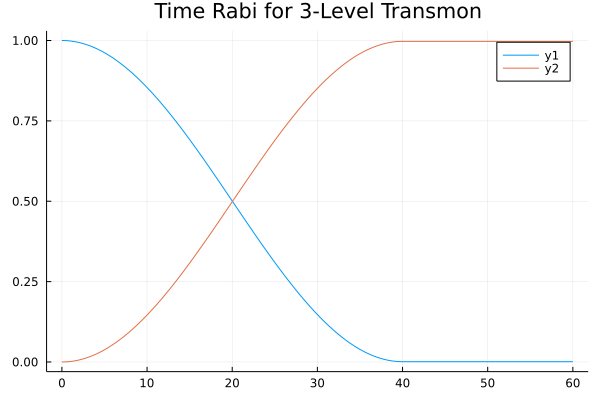

In [387]:
plot(ψsol2.t, abs2.(hcat(ψsol2.u...)[1,:]))
plot!(ψsol2.t, abs2.(hcat(ψsol2.u...)[2,:]))
title!("Time Rabi for 3-Level Transmon")

In [388]:
# Notice how at the end of the gate the excited state population does not fully touch 1
# This means if we use a flat pulse to effect the gate, we will see 

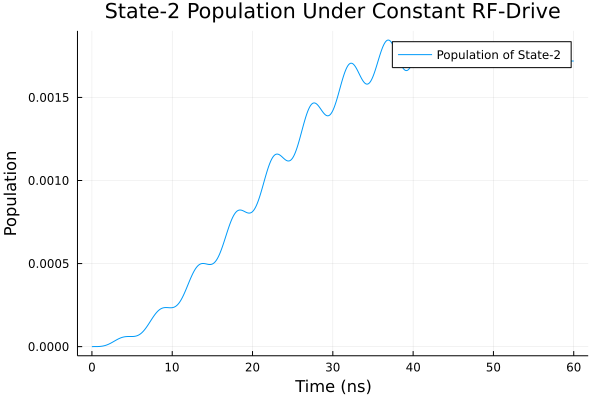

In [389]:
plot(ψsol2.t, abs2.(hcat(ψsol2.u...)[3,:]), label="Population of State-2")
title!("State-2 Population Under Constant RF-Drive")
xlabel!("Time (ns)")
ylabel!("Population")

### 3. Time Evolution with a Shaped Pulse 

Next we explore the dynamics using the the analytical expression as suggested in the paper to show that the given expression indeed reduces the leakage

In [390]:
using ForwardDiff: derivative

In [391]:
# todo, understand if the one-liner is better than this 
# function gaussian_env2(t::Real, tg::Real, nσ::Int=8)
#     u = ((t/tg - 1/2)*(nσ))^2
#     u0 = nσ^2/8 
#     return (exp(u0 - u^2/2) - 1 ) / (exp(u0 - 1))
# end

In [669]:
# Define a pulse shape
"""
Construct a gaussian envelope function that is non-zero only for the duration 0 to tg
"""
gaussian_env(t::Real, tg::Real, nσ::Int=8) = (t/tg - 1/2)*(nσ) |> u -> (exp(nσ^2/8 - u^2/2) - 1 ) / (exp(nσ^2/8) - 1)
get_ℰx(tg::Real, nσ::Int=8) = t::Number -> t <= tg ? gaussian_env(t, tg, nσ) : 0.0
get_ℰy(tg::Real, nσ::Int=8) = t::Number -> derivative(get_ℰx(tg, nσ), t)

get_ℰy (generic function with 2 methods)

In [670]:
# currently only looking at on-resonance behavior
ωd = 4.5
# for now we assume we are in the interaction picture with respect to the rf-drive frame
ωi = ωd;
# constructing the free hamiltonian
δvec = [ω, 2ω+η] - ωi*[1, 2]
h0 = ComplexF64.(setindex!(zeros(ndim), δvec, 2:ndim) |> diagm)
# realistic value of λ ( coupling normalizations )
λ = [1, sqrt(2)]
# operators
xvec = (λ / 2) .*[sigmax(1, 2, 3), sigmax(2, 3, 3)]
yvec = (λ / 2) .*[sigmay(1, 2, 3), sigmay(2, 3, 3)]

2-element Vector{Hermitian{ComplexF64, Matrix{ComplexF64}}}:
 [0.0 + 0.0im -0.0 - 0.5im 0.0 + 0.0im; -0.0 + 0.5im 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im 0.0 - 0.0im 0.0 + 0.0im]
 [0.0 + 0.0im 0.0 + 0.0im 0.0 + 0.0im; 0.0 - 0.0im 0.0 + 0.0im -0.0 - 0.7071067811865476im; 0.0 - 0.0im -0.0 + 0.7071067811865476im 0.0 + 0.0im]

In [394]:
# start with drive pulse only in x-quadrature.
tg = 40
tmax = 60
tf=1
dt = 0.001
times = 0:dt:tmax
fn_ℰx = get_ℰx(tg)
fn_ℰy = get_ℰy(tg)

#71 (generic function with 1 method)

In [395]:
# drive amplitude
ℰ0 = (1/tg/2) * (tg / (sum(fn_ℰx.(times)) * dt))

0.03992612061123449

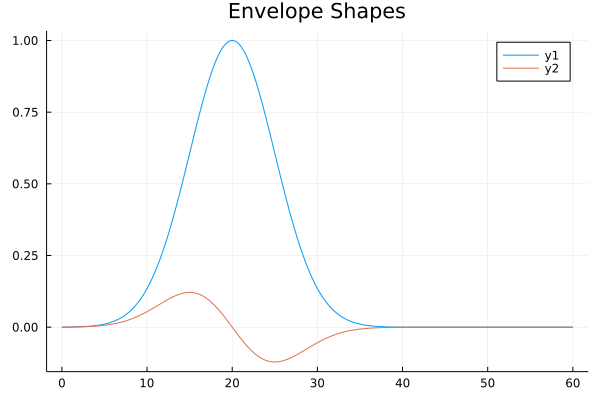

In [396]:
plot(times, fn_ℰx.(times))
plot!(times, fn_ℰy.(times))
title!("Envelope Shapes")

In [397]:
h3ops = [h0, ℰ0.*xvec...]
h3coeffs = [one, fn_ℰx, fn_ℰx]

3-element Vector{Function}:
 one (generic function with 47 methods)
 #69 (generic function with 1 method)
 #69 (generic function with 1 method)

In [398]:
ψ0 = [1., 0., 0]
H3 = DenseHamiltonian(h3coeffs, h3ops, unit=:h)
a3 = Annealing(H3, ψ0)

Annealing with DenseHamiltonian{ComplexF64} and u0 Vector{Float64}
u0 size: (3,)

In [399]:
@time ψsol3 = solve_schrodinger(a3, 1, tspan=(0, tmax), alg=Tsit5(), reltol=1e-6, tstops=0:0.005:tmax);

  0.076186 seconds (1.12 M allocations: 64.782 MiB, 35.16% gc time, 4.98% compilation time)


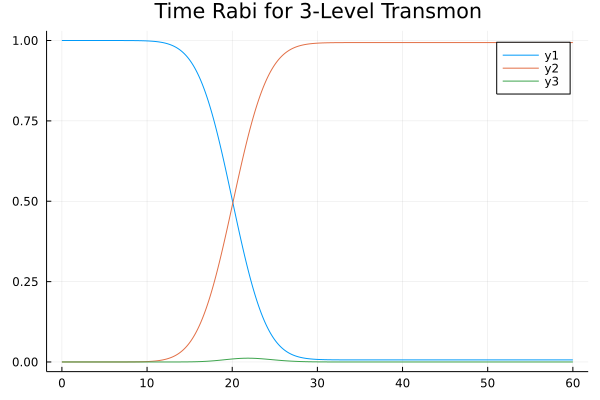

In [400]:
plot(ψsol3.t, abs2.(hcat(ψsol3.u...)[1,:]))
plot!(ψsol3.t, abs2.(hcat(ψsol3.u...)[2,:]))
plot!(ψsol3.t, abs2.(hcat(ψsol3.u...)[3,:]))
title!("Time Rabi for 3-Level Transmon")

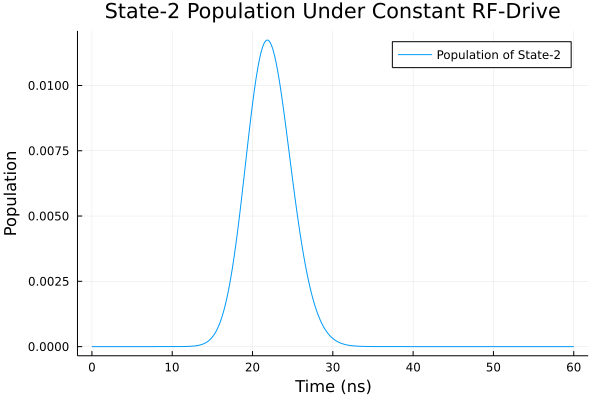

In [401]:
plot(ψsol3.t, abs2.(hcat(ψsol3.u...)[3,:]), label="Population of State-2")
title!("State-2 Population Under Constant RF-Drive")
xlabel!("Time (ns)")
ylabel!("Population")

In [402]:
# todo: why is there dynamics *after* the waveform goes to 0
# fixed. due to tf! it's not the total evolution time!

### 4. Power-Rabi to Find Optimal Pi-Pulse ( w/o DRAG).
In the previous example we evolved the system with a shaped pulse. Next step will be to find the the pi-pulse by fixing gate time

In [1403]:
tg = 20
# drive amplitude
xvec = (λ / 2) .*[sigmax(1, 2, 3), sigmax(2, 3, 3)]
yvec = (λ / 2) .*[sigmay(1, 2, 3), sigmay(2, 3, 3)]

fn_ℰx = get_ℰx(tg)
fn_ℰy = get_ℰy(tg)

ℰ0 = (1/tg/2) * (tg / (sum(fn_ℰx.(times)) * dt))
ψ0 = [1., 0., 0]

3-element Vector{Float64}:
 1.0
 0.0
 0.0

In [1404]:
function state_vs_rf_amp(amp::Real; tg::Real=tg, dt::Real=0.005)
    ops = [h0, amp.*xvec...]
    coeffs = [one, fn_ℰx, fn_ℰx]
    a = Annealing(DenseHamiltonian(coeffs, ops, unit=:h),ψ0)
    sol = solve_schrodinger(a, 1, tspan=(0, tg), alg=Tsit5(), reltol=1e-6, tstops=0:dt:tg, saveat=tg)
    sol.u[end]
end

state_vs_rf_amp (generic function with 1 method)

In [1420]:
amprange = (0.:0.002:0.25)

0.0:0.002:0.25

In [1421]:
@time ψvsamps = state_vs_rf_amp.(amprange);

  2.209256 seconds (42.43 M allocations: 2.086 GiB, 17.28% gc time)


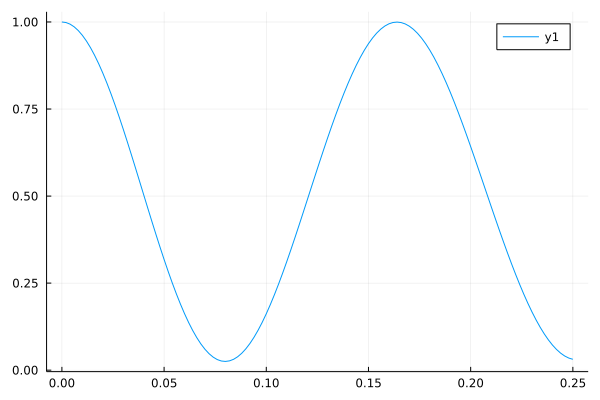

In [1422]:
plot(amprange, abs2.(hcat(ψvsamps...)[1,:]))

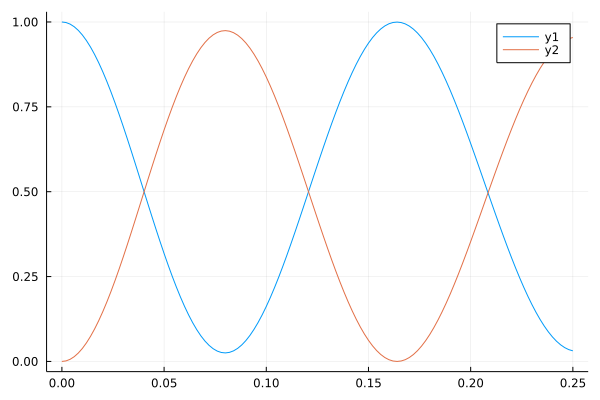

In [1423]:
plot(amprange, abs2.(hcat(ψvsamps...)[1,:]))
plot!(amprange, abs2.(hcat(ψvsamps...)[2,:]))
# at 20ns the leakage is very little! on the order of 1e-3.
# this is all for a fixed value of λ = √2. This value 
# plot!(amprange, 1e3*abs2.(hcat(ψvsamps...)[3,:]), label="1e3*prob state-3")

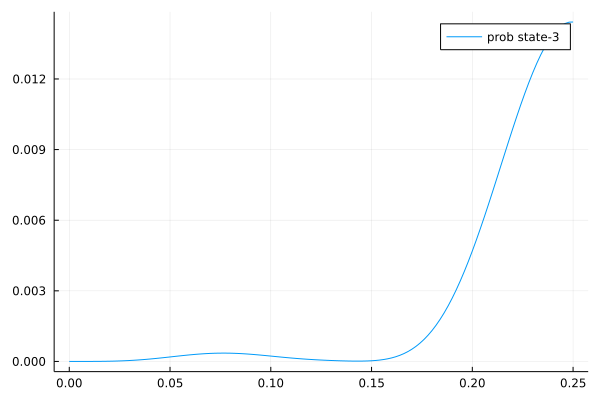

In [1424]:
plot(amprange, abs2.(hcat(ψvsamps...)[3,:]), label="prob state-3")

In [1425]:
# quickly checking the maximum value 
state1_prob, max_id = findmax(abs2.(hcat(ψvsamps...)[2,:]))
state0_prob = abs2.(hcat(ψvsamps...)[1,max_id])
state2_prob = abs2.(hcat(ψvsamps...)[3,max_id])
# todo: implement fidelity metrics; run the dynamics using `solve_unitary` instead of solve_shrodinger

0.00034966608785408663

### 5. Use the Lowest Order DRAG Correction to show it improves the fidelity

Next we'd like to actually implement the gate itself and show that we get an error 

In [1426]:
ωi = 4.5;
# constructing the free hamiltonian
δvec = [ω, ω+η] .- ωi
h0 = ComplexF64.(setindex!(zeros(ndim), δvec, 2:ndim) |> diagm |> Hermitian)

3×3 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im    0.0+0.0im
 0.0+0.0im  0.0+0.0im    0.0+0.0im
 0.0+0.0im  0.0+0.0im  -0.21+0.0im

In [1427]:
# account for rf-power dependent stark shift
h_stark = diagm([0, 1., 2]) 

3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  2.0

In [1428]:
ψ0 = [1., 0., 0]
λ = [1, sqrt(2)]
# Gate Time
tg = 20
# drive amplitude
ℰ0 = (1/tg/2) * (tg / (sum(fn_ℰx.(times)) * dt))
fn_ℰx = get_ℰx(tg)
fn_ℰy = get_ℰy(tg)

δstark(t::Real, η::Real=η) = (λ[2]^2 - 4)/(4*η) * fn_ℰx(t)^2
δstark(η=η) = (λ[2]^2 - 4)/(4*η)

# Expressions for the lowest order DRAG corrections
ℰ0y(ℰ0x::Real, η::Real=η) = -ℰ0x/η

ℰ0y (generic function with 2 methods)

In [1434]:
function state_vs_rf_amp_drag(ℰ0x::Real; tg::Real=tg, dt::Real=0.005)
    ops = [h0, ℰ0x .* xvec..., -ℰ0x/η * yvec..., -(ℰ0x)^2 * (1+1/η^2) .*h_stark ]
    coeffs = [one, fn_ℰx, fn_ℰx,  fn_ℰy, fn_ℰy, δstark]
    a = Annealing(DenseHamiltonian(coeffs, ops, unit=:h), ψ0)
    sol = solve_schrodinger(a, 1, tspan=(0, tg), alg=Tsit5(), reltol=1e-8, tstops=0:dt:tg, saveat=tg)
    sol.u[end]
end

state_vs_rf_amp_drag (generic function with 1 method)

In [1435]:
amprange = (0:0.001:0.075)

0.0:0.001:0.075

In [1431]:
@time ψvsamps = state_vs_rf_amp_drag.(amprange);

  2.755555 seconds (64.12 M allocations: 2.656 GiB, 11.37% gc time, 3.52% compilation time)


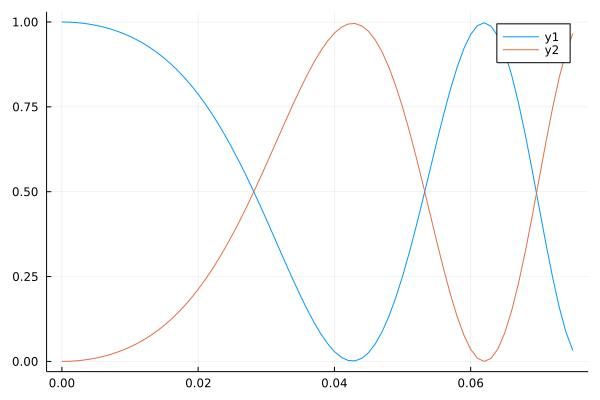

In [1432]:
plot(amprange, abs2.(hcat(ψvsamps...)[1,:]))
plot!(amprange, abs2.(hcat(ψvsamps...)[2,:]))
# at 20ns the leakage is very little! on the order of 1e-3.
# this is all for a fixed value of λ = √2. This value 
# plot!(amprange, 1e3*abs2.(hcat(ψvsamps...)[3,:]), label="1e3*prob state-3")

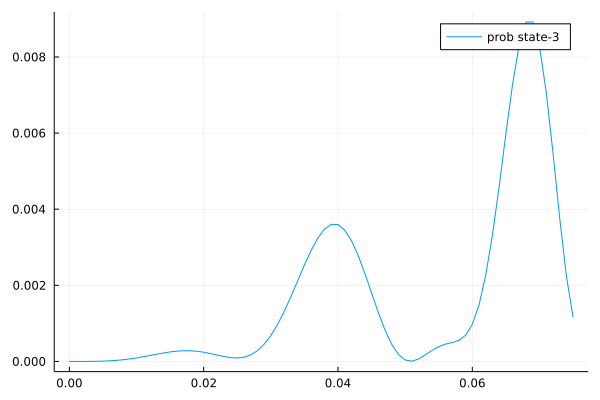

In [1433]:
plot(amprange, abs2.(hcat(ψvsamps...)[3,:]), label="prob state-3")
# ylims!(0, 0.001)

### 5. Set up a Simulation to Numerically Tune up the Drag Coefficient

In this example, we use the `DenseHamiltonian` [type](https://docs.julialang.org/en/v1/manual/types/#man-types). It means that the underlying data structure of this Hamiltonian type is [Julia array](https://docs.julialang.org/en/v1/manual/arrays/). There exists a different Hamiltonian type named `SparseHamiltonian` that relies on [sparse array](https://docs.julialang.org/en/v1/stdlib/SparseArrays/) as its internal data structure. Sparsity can only provide performance improvement when the system size is large. So, as a rule of thumb, users should only consider using `SparseHamiltonian` when the system size is larger than 10 qubits. 

The closed-system evolution is completely specified by the Hamiltonian and the initial state. We can combine them into a single `Annealing` object by:

#### Unitary
Lastly, we can also solve the unitary

$$U(s) = T_+ \exp\bigg\{ -i t_f \int_0^s H(s') \mathrm{d}s' \bigg\}$$

using `solve_unitary`. The ODE form of the problem is

$$\dot{U} = -i t_f H(s) U \ .$$

Although this is in principle equivalent to the Schrodinger/Von Neumann equation, the unitary becomes handy in certain cases, e.g., when solving the Redfield equation.

In [823]:
annealing = Annealing(H, u0)
sol_tsit = solve_unitary(annealing, tf, alg=Tsit5(),abstol=1e-6, reltol=1e-6)
sol_tsit(0.5 * tf)

LoadError: UndefVarError: H not defined

Again we plot the $\langle X \rangle$ obtained by multiplying the unitary by the initial state.

In [ ]:
# using HOQSTTutorials
# HOQSTTutorials.tutorial_footer(WEAVE_ARGS[:folder],WEAVE_ARGS[:file])